In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, KFold
import os
import sys
import math
import scipy
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

package_path,current = os.path.split(module_path)
if package_path not in sys.path:
    sys.path.append(package_path)

from data_preprocessing import experiments, process_daily_activities, foldLaundry, writeHello, openJar, screwLightbulb, combHair, tieShoes
from hdc import hdc
import full_accelerometer_classification as HDC_sb_flow


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
%%time
# loading data

feat_dir = os.getcwd() + '/../../S1/features/'
sub = 1
temporal_ngram = 2
downsample_factor = 1
feature_window = 50
seed = 12345
split_seed = 1
D = 10000

accSpan = [-1,1]
accCIMLevels = [59, 55, 14]
accCIMSpan = [10000, 5000, 6000]
accIMLevels = [1, 4, 5]

temporal_ngrams = [3]
downsample_factors = [1]
#feature_windows = [50,100,200,500,1000]
feature_windows = [50]
subtask_accuracies = np.zeros([len(temporal_ngrams),len(downsample_factors)])
task_accuracies = np.zeros([len(temporal_ngrams),len(downsample_factors)])

#for i in range(len(temporal_ngrams)):
#    for y in range(len(feature_windows)):
#        temporal_ngram = temporal_ngrams[i]
#        #downsample_factor = downsample_factors[y]
#        feature_window = feature_windows[y]
#        subtask_accuracies[i,y], task_accuracies[i,y] = HDC_sb_flow.HDC_flow(feat_dir, sub, temporal_ngram, downsample_factor, feature_window, seed, split_seed, D,accSpan,accCIMLevels,accCIMSpan,accIMLevels)
subtask_label,accelerometer_data,emg_data,data_during_subtask = HDC_sb_flow.HDC_flow(feat_dir, sub, temporal_ngram, downsample_factor, feature_window, seed, split_seed, D,accSpan,accCIMLevels,accCIMSpan,accIMLevels)
#print("The sub-task recognition accuracies for the range of parameters is: ", subtask_accuracies)
#print("The task recognition accuracies for the range of parameters is: ", task_accuracies)


accelerometer_data = accelerometer_data[data_during_subtask]

plt.rcParams["figure.figsize"] = (15,10)
# plt.axvline(foldLaundry['actionLength']*100*5, ymin, ymax, color='black', linestyle='dotted', linewidth=5)
# plt.axvline((foldLaundry['actionLength']*100 + writeHello['actionLength']*100)*5, ymin, ymax, color='black', linestyle='dotted', linewidth=5)
# plt.axvline((foldLaundry['actionLength']*100 + writeHello['actionLength']*100 + openJar['actionLength']*100)*5, ymin, ymax, color='black', linestyle='dotted', linewidth=5)
# plt.axvline((foldLaundry['actionLength']*100 + writeHello['actionLength']*100 + openJar['actionLength']*100 + screwLightbulb['actionLength']*100)*5, ymin, ymax, color='black', linestyle='dotted', linewidth=5)
# plt.axvline((foldLaundry['actionLength']*100 + writeHello['actionLength']*100 + openJar['actionLength']*100 + screwLightbulb['actionLength']*100 + combHair['actionLength']*100)*5, ymin, ymax, color='black', linestyle='dotted', linewidth=5)
# plt.plot(accelerometer_data)
# plt.xlim(0,37500)
# plt.ylim(-1.5,2)

# plt.text(100, 1.75, 'Folding Laundry', fontsize = 10)
# plt.text(6250, 1.75, 'Writing Hello', fontsize = 10)
# plt.text(13500, 1.75, 'Opening Jar', fontsize = 10)
# plt.text(19500, 1.75, 'Screwing Lightbulb', fontsize = 10)
# plt.text(27500, 1.75, 'Combing Hair', fontsize = 10)
# plt.text(33500, 1.75, 'Tying Shoeslaces', fontsize = 10)

shape of emgFeature: (49500, 59)
shape of labels: (1, 49500)
49399
CPU times: user 41.5 ms, sys: 27.7 ms, total: 69.2 ms
Wall time: 71.1 ms


In [17]:
print(accelerometer_data.shape)
first_task = np.where(subtask_label < 100)[1]
first_task = accelerometer_data[first_task]
print(first_task.shape)

(37500, 3)
(4000, 3)


In [18]:
filename = feat_dir + 'daily_activities_' + 'S' + f'{sub:03}' + '_features.mat'
data = sio.loadmat(filename)

In [19]:
data_acc = data['accFeature_disc']
#remove irrelevant accelerometer data
holdaccIdx = np.where(data['subGestureLabel_disc'] >= 0)[1]
yaccAll = data['subGestureLabel_disc'][:,holdaccIdx]

In [20]:
task_locations = [[]] * 6
task_locations[0] = np.where(subtask_label < 100)[1]
task_locations[1] = np.where((subtask_label >= 100) & (subtask_label < 200))[1]
task_locations[2] = np.where((subtask_label >= 200) & (subtask_label < 300))[1]
task_locations[3] = np.where((subtask_label >= 300) & (subtask_label < 400))[1]
task_locations[4] = np.where((subtask_label >= 400) & (subtask_label < 500))[1]
task_locations[5] = np.where((subtask_label >= 500) & (subtask_label < 600))[1]
        
a_labels=[[]]*6
a_labels[0]=['ReachOut','Pinch','LiftUp','Move','PutDown','Fold','Release','Return']
a_labels[1]=['Reach','Thumb','HandDown','Pinch','LiftPen','Rot-Wrist','Paper','PenDown','Hello','PenUp','PenBack','Rot-wrist','PenDown','Ret-Wrist','Ret-Neutral']
a_labels[2]=['PlaceHand','PowerGrip','HandDown','Grip','Untwist','ReAlign','Untwist','ReAlign','Untwist','ReAlign','Untwist','ReAlign','PlaceCap','Neutral']
a_labels[3]=['HandOver','HandDown','Place','Align','Twist','Align','Twist','Align','Twist','Align','Twist','Align','Neutral']
a_labels[4]=['HandOver','HandOnto','Slide','LiftRight','GripRight','LeftDone','LiftComb','Comb','LiftComb','Comb','LiftComb','Comb','LiftComb','Comb','PutDown','Neutral']
a_labels[5]= ['HandOver','Grip','LeftLoop','RightLoop','RightPinch','LeftPinch','PullThrough','Release','Return']

activity_names = ['foldLaundry', 'writeHello','openJar', 'screwLightbulb', 'combHair', 'tieShoes']


In [21]:
import data_preprocessing as data_prep

def extract_dataset(task_locations,a_labels,data_prep,task_num):
    action_length=len(a_labels[task_num]*100)
    task_len=len(data_prep.experiments)

    data_info = [foldLaundry, writeHello, openJar, screwLightbulb, combHair, tieShoes]
    activity_names = ['foldLaundry', 'writeHello','openJar', 'screwLightbulb', 'combHair', 'tieShoes']
        
        
    first_task = task_locations[task_num]  # np.where(subtask_label < 100)[1]
    first_task_labels = subtask_label[0][first_task]
    first_task = accelerometer_data[first_task]
    labels = a_labels[task_num]
    first_task_switch=first_task
#     first_task_switch = np.zeros(shape=(first_task.shape[0],first_task.shape[1]))
#     for i in range(3):
#         first_task_switch [:,i] = np.concatenate((first_task[40:,i],first_task[action_length:action_length+40,i]),axis=0)
    return first_task_switch


In [22]:
def subplots_tasks(first_task_switch,num_acts,labels):
#     first_task_3ds=np.array([np.transpose(first_task_switch[100*i:100*(i+1),:]) for i in range(num_acts*5)])
    first_task_3ds=np.array([np.transpose(first_task_switch[100*i:100*(i+1),:]) for i in range(num_acts*5)])
    num_subplots=int(num_acts/2)
    if num_acts/2%2!=0:
        num_subplots+=1
    for i in range(5):
        for j in range(num_acts):
    #     for j in range(7):
            plt.subplot(2,num_subplots,j+1)
            plt.plot(first_task_3ds[(num_acts*i)+j][0][:],'C0')
            plt.plot(first_task_3ds[(num_acts*i)+j][1][:],'C1')
            plt.plot(first_task_3ds[(num_acts*i)+j][2][:],'C2')
            plt.title(labels[j])
#             plt.legend(['Axis1','Axis2','Axis3'])

foldLaundry


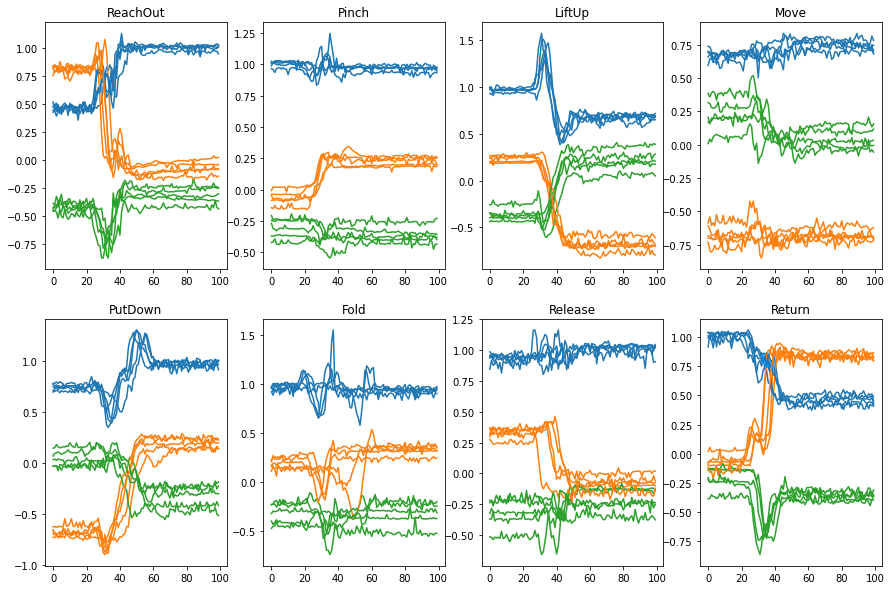

In [23]:
task_num=0
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])
plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)


writeHello


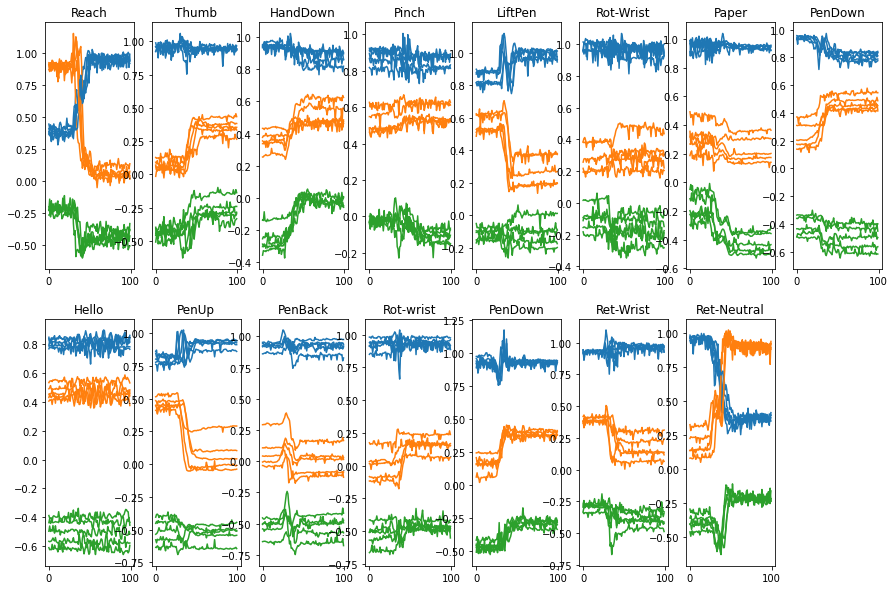

In [24]:
task_num=1
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])
plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)

openJar


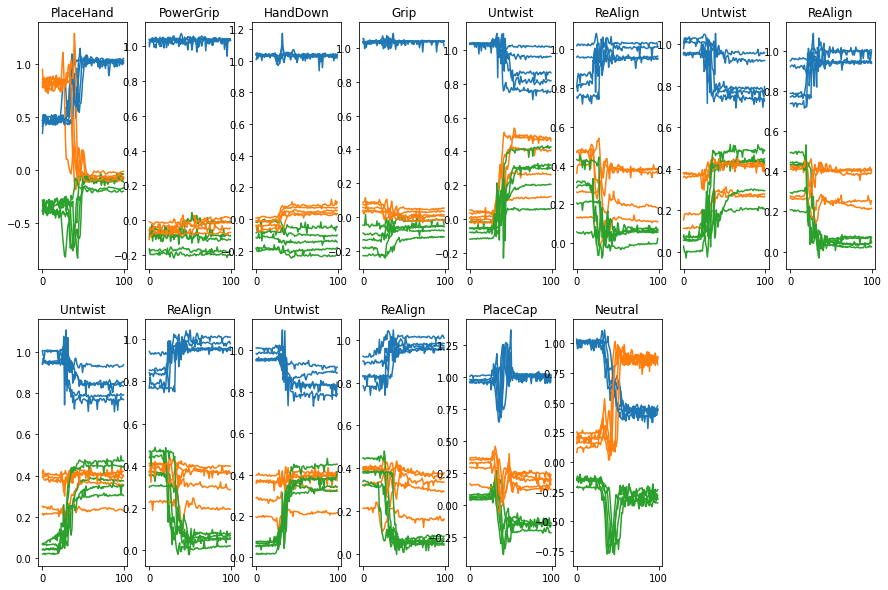

In [25]:
task_num=2
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])

plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)

screwLightbulb


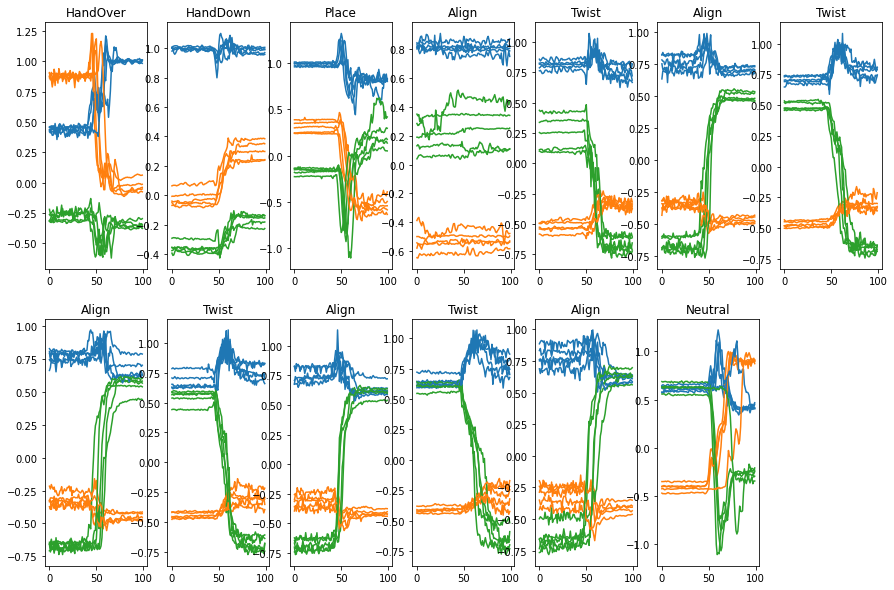

In [26]:
task_num=3
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])
plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)

combHair


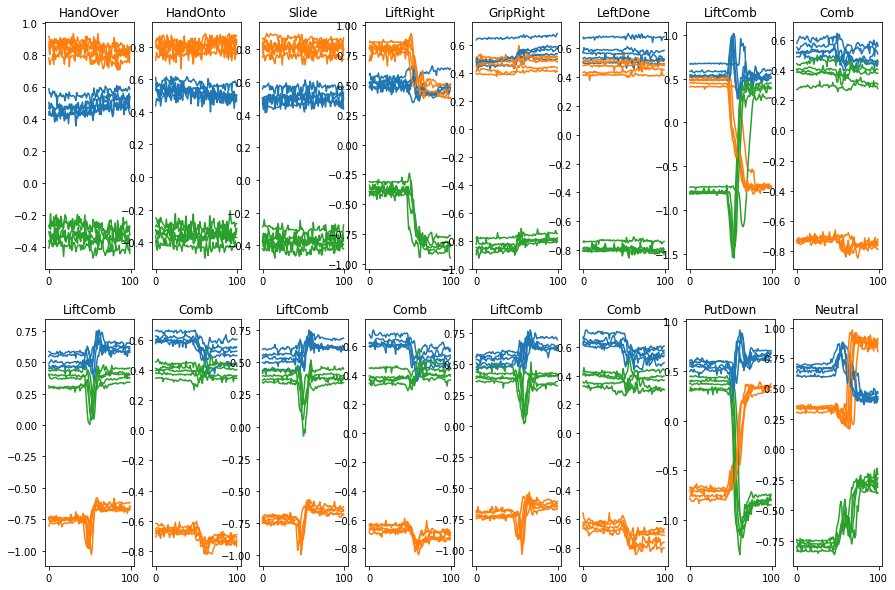

In [27]:
task_num=4
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])

plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)

tieShoes


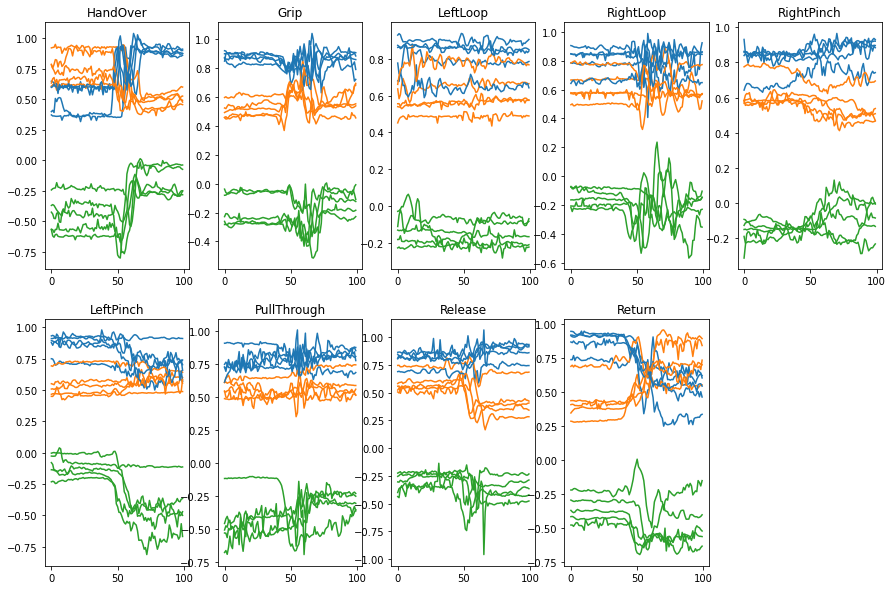

In [28]:
task_num=5
current_task=extract_dataset(task_locations,a_labels,data_prep,task_num)

action_length=len(a_labels[task_num]*100)
labels=a_labels[task_num]
print(activity_names[task_num])

plt.figure(1)
subplots_tasks(current_task,len(a_labels[task_num]),labels)

In [29]:

# from matplotlib.pyplot import figure

# barWidth = 0.25
# br1=list(range(7))
# br2 = [x + barWidth for x in br1]
# names=['foldLaundry', 'writeHello', 'openJar', 'screwLightbulb', 'combHair', 'tieShoes','all']

# figure(figsize=(10, 6))

# plt.bar(br1, HDC_EMG_acc, color ='r', width = barWidth,label='HDC with EMG')
# plt.bar(br2, rocket_accel_acc, color ='b', width = barWidth,label='Timeseries (Rocket) acceletometer')
# plt.legend()
# plt.xticks(br1,names)
# plt.ylabel('Accuracy')
# plt.xlabel('Activity')
# plt.grid()